In [1]:
# Check interarrival times for SPCM
# Grant Kirchhoff
# Last updated: 02.10.2023

import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import os
import sys

cwd = os.getcwd()
sys.path.append(os.getcwd()+'\..\library')

from load_ARSENL_data import load_INPHAMIS_data

In [2]:
start = time.time()

# Constants
c = 299792458  # [m/s] Speed of light

# Parameters
create_csv = 0  # Set true to generate a .csv from .ARSENL data
load_data = True  # Set true to load data into a DataFrame and serialize into a pickle object
picklename = 'spcm_OD2.0'

data_dir = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\SPCM_Data_2023.02.06'
fname = r'\Dev_0_-_2023-02-06_16.44.21_OD2.0.ARSENL'

# Load INPHAMIS .ARSENL data if not yet serialized
if load_data:
    df = load_INPHAMIS_data(data_dir, fname, picklename, create_csv)

Elapsed time (read pd): 2.0588977336883545 sec


In [3]:
# Unpickle the data to DataFrame object
infile = open('{}/{}'.format(data_dir, picklename), 'rb')
df = pickle.load(infile)
infile.close()

In [4]:
df = df[:100000]

In [5]:
detect = df.loc[(df['overflow'] == 0) & (df['channel'] == 0)]  # Return data for detection event ("overflow","channel" = 0,0)
sync = df.loc[(df['overflow'] == 1) & (df['channel'] == 0)]
rollover = df.loc[(df['overflow'] == 1) & (df['channel'] == 63)]
n_shots = len(sync)
n_rollover = len(rollover)

In [6]:
detect_idx = np.array(detect.index)  # Indices of dark count events
sync_detect_idx = np.array(detect_idx) - 1  # Extract index immediately prior to dark count event to match with laser pulse
sync_detect = df.loc[sync_detect_idx]  # Laser pulse event prior to dark count event
rollover_idx = np.array(rollover.index)
# Note: I don't know if there is any significance to tracking the laser pulse that occurs prior to each dark count event but it might be useful to have...

detect_time = detect['dtime'].to_numpy()
sync_detect_time = sync_detect['dtime'].to_numpy()

Number of rollovers per dark count event: 
[0. 0. 0. ... 0. 0. 0.]


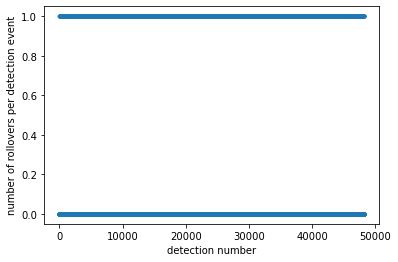

In [7]:
# Function that uses rolloevers to convert detection time stamps from relative to global
prev_num_rolls = 0
track_rolls = np.zeros(len(detect_idx))
for i in range(len(detect_idx)):
    prev_roll_idx = np.argmin(np.abs(detect_idx[i] - rollover_idx))
    if rollover_idx[prev_roll_idx] > detect_idx[i]:
        prev_roll_idx -= 1
    num_rolls = prev_roll_idx + 1 - prev_num_rolls
    prev_num_rolls += num_rolls
    
    track_rolls[i] = num_rolls
    
print('Number of rollovers per dark count event: \n{}'.format(track_rolls))

plt.plot(track_rolls, '.')
plt.xlabel('detection number')
plt.ylabel('number of rollovers per detection event')
plt.show()


In [8]:
roll_cnts = 2**25
total_rolls_before_detect = np.cumsum(track_rolls)
total_cnts_before_detect = roll_cnts * total_rolls_before_detect
detect_cnts = detect_time + total_cnts_before_detect

In [9]:
spec_dcr = np.array([43, 500])  # [Hz] [Measured, Max]
spec_dc_period = 1 / spec_dcr

spec_deadtime = 29.1e-9  # [s]

In [10]:
detect_global_time = detect_cnts * 25e-12 # [s] convert from clock count to s
detect_inter_time = np.diff(detect_global_time)

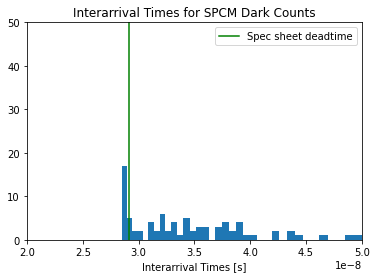

In [29]:
use_log = False

num_bins = 100
lin_bins = np.linspace(np.min(detect_inter_time), np.max(detect_inter_time), num_bins+1)
log_bins = np.logspace(np.log10(np.min(detect_inter_time)), np.log10(np.max(detect_inter_time)), num_bins+1)
log_bins = np.logspace(np.log10(20e-9), np.log10(100e-9), num_bins+1)

fig = plt.figure()
ax = fig.add_subplot(111)
if use_log:
    ax.hist(detect_inter_time, log_bins)
    ax.set_xscale('log')
else:
    ax.hist(detect_inter_time, log_bins)
ax.set_xlabel('Interarrival Times [s]')
ax.set_title('Interarrival Times for SPCM Dark Counts')
ax.set_xlim([2.0e-8, .5e-7])
ax.set_ylim([0, 50])
# plt.axvline(x=spec_dc_period[0], color='r', label='Dark Count Period Range')
# plt.axvline(x=spec_dc_period[1], color='r')
plt.axvline(x=spec_deadtime, color='g', label="Spec sheet deadtime")
plt.legend()
plt.show()